In [1]:
%load_ext autoreload
%autoreload 2

https://jsideas.net/dqn/

https://github.com/junkwhinger/dqn/blob/master/DQN_training.ipynb

## Common Codes

### 1. Import the Necessary Packages

In [2]:
import numpy as np
import random
from collections import namedtuple, deque

import gym
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


### 3. Common Variables

In [4]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## DQN

In [6]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
class DQN_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def get_policy_probs(self, action, eps):
        policy_probs = np.ones(self.action_size) * (eps / self.action_size)
        policy_probs[action] += (1-eps)
        
        return policy_probs
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        return np.random.choice(self.action_size, p=self.get_policy_probs(np.argmax(action_values.cpu().data.numpy()), eps))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Target Network's Maximum Q-value
        # max(dim) -> tuple(value, indices)
        # unsqueeze(dim): [64] -> [64, 1]
        target = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        target = rewards + (gamma * target * (1-dones))
        
        # Local Network's Q-value of actual actions
        # gather(dim, index)
        expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = F.mse_loss(expected, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Episode 100	Average Score: -166.27
Episode 200	Average Score: -104.94
Episode 300	Average Score: -66.526
Episode 400	Average Score: -23.25
Episode 500	Average Score: 20.511
Episode 600	Average Score: 149.43
Episode 700	Average Score: 182.81
Episode 752	Average Score: 200.17
Environment solved in 652 episodes!	Average Score: 200.17


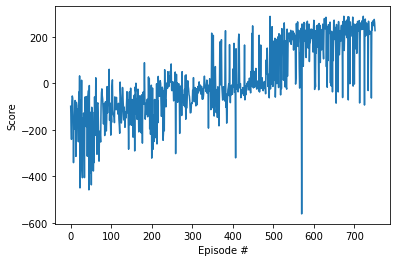

In [9]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'dqn_checkpoint.pth')
            break
    return scores

dqn_agent = DQN_Agent(state_size=8, action_size=4, seed=0)
dqn_scores = dqn(dqn_agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dqn_scores)), dqn_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Double DQN

In [15]:
class DDQN_Agent:

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def get_policy_probs(self, action, eps):
        policy_probs = np.ones(self.action_size) * (eps / self.action_size)
        policy_probs[action] += (1-eps)
        
        return policy_probs

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        return np.random.choice(self.action_size, p=self.get_policy_probs(np.argmax(action_values.cpu().data.numpy()), eps))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Local Network's Greedy Actions (Maximum Q-value)
        greedy_action = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)

        target = self.qnetwork_target(next_states).detach().gather(1, greedy_action)
        target = rewards + (gamma * target * (1-dones))

        expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(expected, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Episode 100	Average Score: -180.45
Episode 200	Average Score: -115.87
Episode 300	Average Score: -63.330
Episode 400	Average Score: 13.943
Episode 500	Average Score: 17.27
Episode 600	Average Score: 159.01
Episode 669	Average Score: 201.32
Environment solved in 569 episodes!	Average Score: 201.32


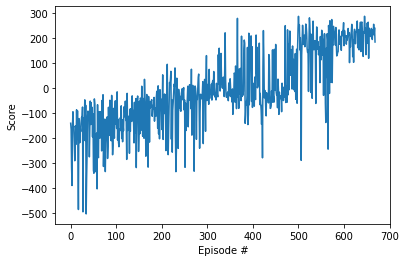

In [16]:
def ddqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'ddqn_checkpoint.pth')
            break
    return scores

ddqn_agent = DDQN_Agent(state_size=8, action_size=4, seed=0)
ddqn_scores = ddqn(ddqn_agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(ddqn_scores)), ddqn_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Prioritized Experience Replay

In [142]:
class PrioritizedReplayBuffer:
    def __init__(self, buffer_size, batch_size, prob_alpha=0.6, prob_beta=0.5, seed=0):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)  
        self.priorities = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.prob_alpha = prob_alpha
        self.prob_beta = prob_beta
        self.pos = 0
        
    def add(self, state, action, reward, next_state, done):
        max_priority = np.max(self.priorities) if len(self.memory) > 0 else 1
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        self.priorities.append(max_priority)
        
    def sample(self, completion):
        beta = self.prob_beta + (1 - self.prob_beta) * completion
            
        prob_a = np.array(self.priorities) ** self.prob_alpha
        p_i = prob_a / prob_a.sum()
        
        sampled_indices = np.random.choice(len(self.memory), self.batch_size, p=p_i)
        experiences = [self.memory[idx] for idx in sampled_indices]
        
        N = len(self.memory)
        weights = (N * p_i[sampled_indices]) ** (-1 * beta)
        weights = weights / weights.max()
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        weights = torch.from_numpy(np.vstack(weights)).float().to(device)
  
        return (states, actions, rewards, next_states, dones, sampled_indices, weights)

    def update_priorities(self, batch_indicies, batch_priorities):
        for idx, priority in zip(batch_indicies, batch_priorities):
            self.priorities[idx] = priority[0]
            
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [143]:
class DDQN_PER_Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = PrioritizedReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def get_policy_probs(self, action, eps):
        policy_probs = np.ones(self.action_size) * (eps / self.action_size)
        policy_probs[action] += (1-eps)
        
        return policy_probs

    def step(self, state, action, reward, next_state, done, completion):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(completion)
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        return np.random.choice(self.action_size, p=self.get_policy_probs(np.argmax(action_values.cpu().data.numpy()), eps))

    def learn(self, experiences, gamma, p_eps=1e-5):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, sample_indices, weights = experiences

        # Local Network's Greedy Actions (Maximum Q-value)
        greedy_action = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)

        target = self.qnetwork_target(next_states).gather(1, greedy_action)
        target = rewards + (gamma * target * (1-dones))

        expected = self.qnetwork_local(states).gather(1, actions)
        
        td_err = target - expected
        
        loss = ((td_err ** 2) * weights).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.memory.update_priorities(sample_indices, td_err.abs().detach().cpu().numpy() + p_eps)
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Episode 100	Average Score: -190.70
Episode 200	Average Score: -96.950
Episode 300	Average Score: -37.42
Episode 400	Average Score: 19.425
Episode 500	Average Score: 80.92
Episode 600	Average Score: 144.31
Episode 700	Average Score: 176.43
Episode 743	Average Score: 200.06
Environment solved in 643 episodes!	Average Score: 200.06


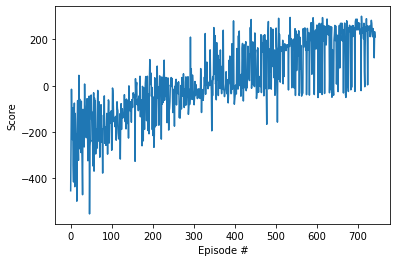

In [144]:
def ddqn_per(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done, i_episode/n_episodes)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'ddqn_per_checkpoint.pth')
            break
    return scores

ddqn_per_agent = DDQN_PER_Agent(state_size=8, action_size=4, seed=0)
ddqn_per_scores = ddqn_per(ddqn_per_agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(ddqn_per_scores)), ddqn_per_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Dueling DQN

In [148]:
class Dueling_QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Dueling_QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3_action = nn.Linear(64, action_size)
        self.fc3_state = nn.Linear(64, 1)
        
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action_out = self.fc3_action(x)
        state_out = self.fc3_state(x)
        
        output = state_out + (action_out - ((1 / self.action_size) * action_out))
        return output

In [149]:
class Dueling_PER_Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = Dueling_QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = Dueling_QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = PrioritizedReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def get_policy_probs(self, action, eps):
        policy_probs = np.ones(self.action_size) * (eps / self.action_size)
        policy_probs[action] += (1-eps)
        
        return policy_probs

    def step(self, state, action, reward, next_state, done, completion):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(completion)
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        return np.random.choice(self.action_size, p=self.get_policy_probs(np.argmax(action_values.cpu().data.numpy()), eps))

    def learn(self, experiences, gamma, p_eps=1e-5):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, sample_indices, weights = experiences
        
        # Local Network's Greedy Actions (Maximum Q-value)
        greedy_action = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)

        target = self.qnetwork_target(next_states).gather(1, greedy_action)
        target = rewards + (gamma * target * (1-dones))

        expected = self.qnetwork_local(states).gather(1, actions)
        
        td_err = target - expected
        
        loss = ((td_err ** 2) * weights).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.memory.update_priorities(sample_indices, td_err.abs().detach().cpu().numpy() + p_eps)
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Episode 100	Average Score: -180.51
Episode 200	Average Score: -115.73
Episode 300	Average Score: -55.923
Episode 400	Average Score: -4.353
Episode 500	Average Score: 123.48
Episode 553	Average Score: 203.30
Environment solved in 453 episodes!	Average Score: 203.30


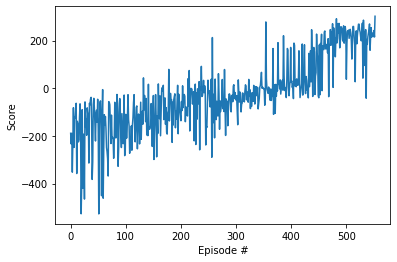

In [150]:
def dueling_per(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done, i_episode/n_episodes)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'dueling_per_checkpoint.pth')
            break
    return scores

dueling_per_agent = Dueling_PER_Agent(state_size=8, action_size=4, seed=0)
dueling_per_scores = dueling_per(dueling_per_agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dueling_per_scores)), dueling_per_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [151]:
len(dqn_scores), len(ddqn_scores), len(ddqn_per_scores), len(dueling_per_scores)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(len(dueling_per_scores)), dueling_per_scores)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.show()

(752, 669, 743, 553)

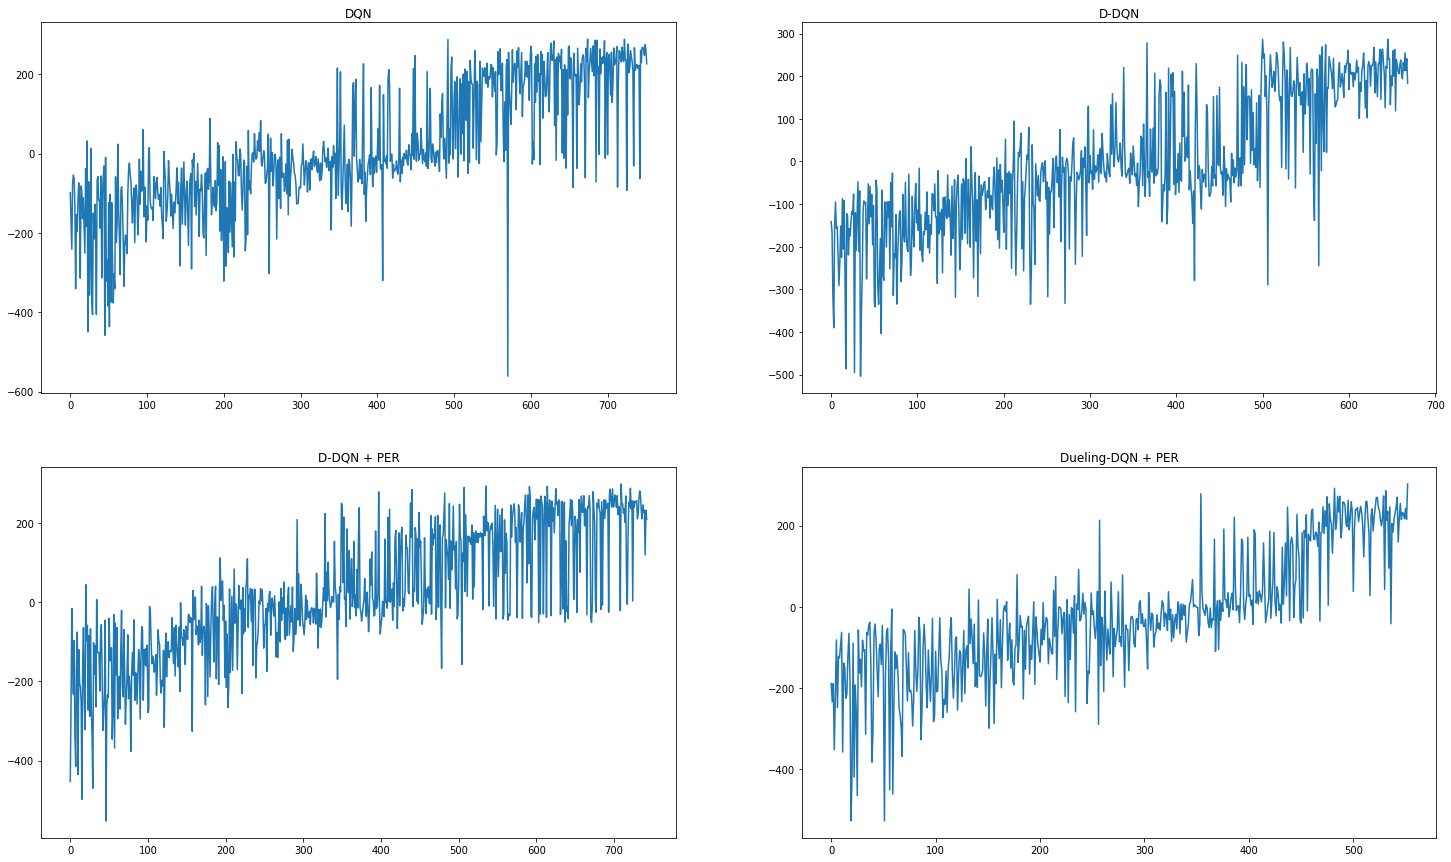

In [166]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,15))
scores_list = [dqn_scores, ddqn_scores, ddqn_per_scores, dueling_per_scores]
scores_title = ['DQN', 'D-DQN', 'D-DQN + PER', 'Dueling-DQN + PER']
for idx, scores in enumerate(scores_list):
    row_idx = int(idx / 2)
    col_idx = idx % 2
    ax = axes[row_idx][col_idx]
    ax.plot(np.arange(len(scores_list[idx])), scores_list[idx])
    ax.set_title(scores_title[idx])

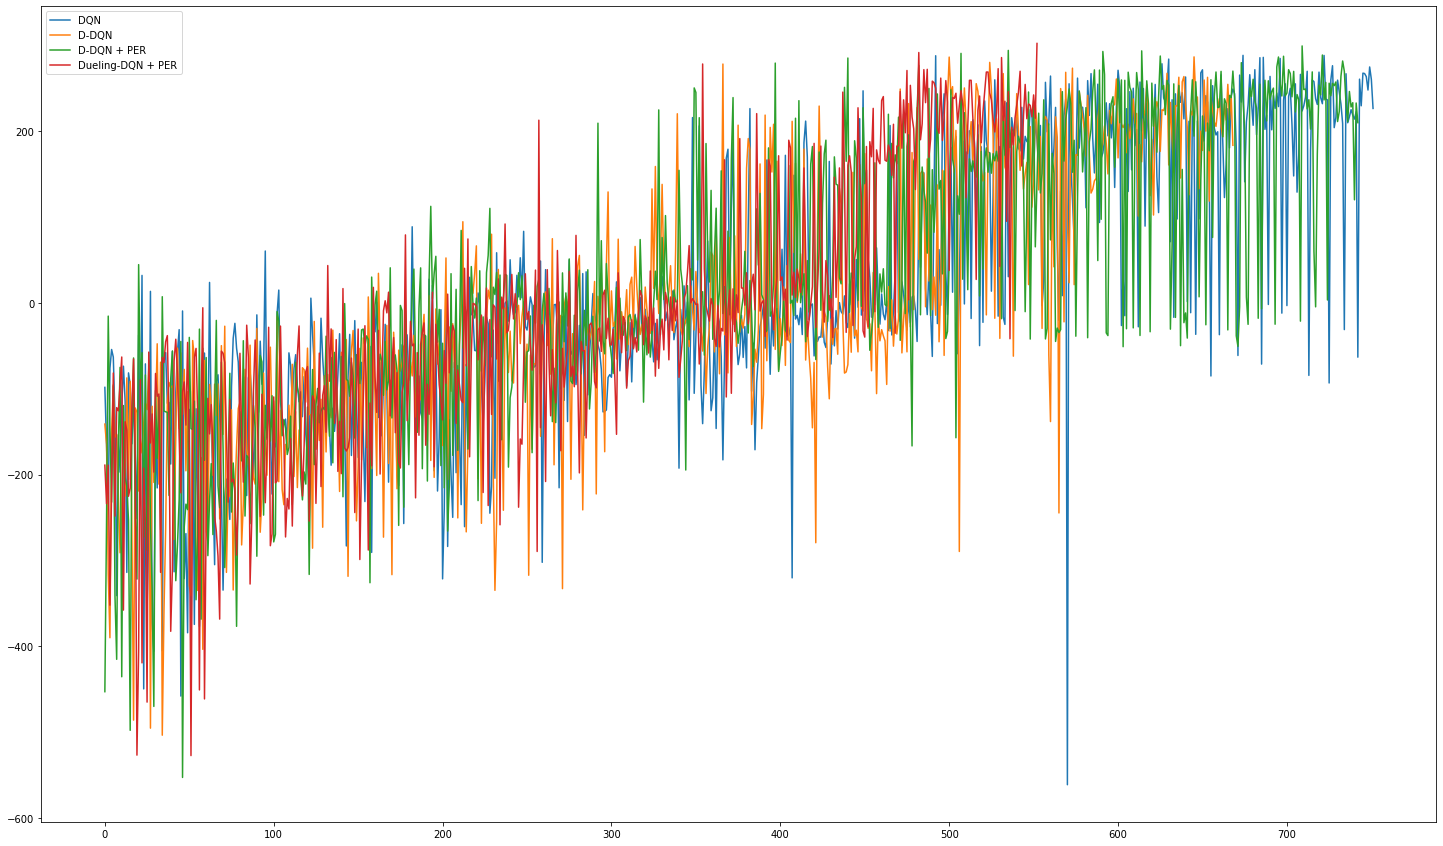

In [181]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
for idx, scores in enumerate(scores_list):
    ax.plot(np.arange(len(scores_list[idx])), scores_list[idx], label=scores_title[idx])
ax.legend()